Install Dependencies and Import Required Packages

In [1]:
!sudo add-apt-repository ppa:openjdk-r/ppa
!sudo apt-get install openjdk-11-jdk
# To Install Oracke JDK varsion 8
# !sudo add-apt-repository ppa:webupd8team/java
# !sudo apt-get install oracle-java8-installer
!sudo apt install -y openjdk-8-jdk


 
 More info: https://launchpad.net/~openjdk-r/+archive/ubuntu/ppa
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:11 http://ppa.launchpad.net/openjdk-r/ppa/ubuntu focal InRelease [23.8 kB]
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/u

In [2]:
!wget -q https://downloads.apache.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop3.2.tgz
!tar xvzf spark-3.2.3-bin-hadoop3.2.tgz
!pip install pyspark
!pip install -q findspark
!pip install pyarrow
try:
  # %tensorflow_version only exists in Colab.
  !pip install  tf-estimator-nightly==2.8.0.dev2021122109
except Exception:
  pass

spark-3.2.3-bin-hadoop3.2/
spark-3.2.3-bin-hadoop3.2/LICENSE
spark-3.2.3-bin-hadoop3.2/NOTICE
spark-3.2.3-bin-hadoop3.2/R/
spark-3.2.3-bin-hadoop3.2/R/lib/
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/DESCRIPTION
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/INDEX
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/Meta/
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/Meta/Rd.rds
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/Meta/features.rds
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/Meta/hsearch.rds
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/Meta/links.rds
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/Meta/nsInfo.rds
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/Meta/package.rds
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/Meta/vignette.rds
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/NAMESPACE
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/R/
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/R/SparkR
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/R/SparkR.rdb
spark-3.2.3-bin-hadoop3.2/R/lib/SparkR/R/SparkR.rdx
spark-3.2.3-bin-hadoop3.2/R/lib/Sp

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-3.2.3"


In [4]:
from pyspark.sql.functions import col, pandas_udf, regexp_extract
import io

from tensorflow.keras.applications.imagenet_utils import decode_predictions
import pandas as pd
from pyspark.sql.functions import col, pandas_udf, PandasUDFType

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pathlib
import findspark

from pyspark.sql import SparkSession
import matplotlib.pyplot as plt 


findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()  #starting the spark session

Download the Public Dataset - CIFAR10

In [5]:
data_dir = tf.keras.utils.get_file(origin='https://mmlspark.azureedge.net/datasets/CIFAR10/train.zip',extract = True)

print(data_dir)

127708997/127708997 [==============================] - 6s 0us/step
/root/.keras/datasets/train.zip


Recursively Read all the Images from the Parent directory and create a DataFrame

In [6]:
images = spark.read.format("binaryFile").option("recursiveFileLookup", "true").option("pathGlobFilter", "*.png").load(data_dir[:-4])
print(type(images))

<class 'pyspark.sql.dataframe.DataFrame'>


In [7]:
images.select("path").show(5) 

+--------------------+
|                path|
+--------------------+
|file:/root/.keras...|
|file:/root/.keras...|
|file:/root/.keras...|
|file:/root/.keras...|
|file:/root/.keras...|
+--------------------+
only showing top 5 rows



In [8]:
files=images.select('path').rdd.map(lambda x :x.path ).collect()
files[0:10]

['file:/root/.keras/datasets/train/29920-02.png',
 'file:/root/.keras/datasets/train/18370-06.png',
 'file:/root/.keras/datasets/train/39576-04.png',
 'file:/root/.keras/datasets/train/02898-06.png',
 'file:/root/.keras/datasets/train/20310-06.png',
 'file:/root/.keras/datasets/train/29550-06.png',
 'file:/root/.keras/datasets/train/06510-06.png',
 'file:/root/.keras/datasets/train/34823-06.png',
 'file:/root/.keras/datasets/train/44783-02.png',
 'file:/root/.keras/datasets/train/07348-06.png']

In [9]:
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import when
def extract_label(path_col):
  """Extract label from file path using built-in SQL functions."""
  return regexp_extract(path_col, r'(\d{2})\.png$', 1)

def extract_size(content):
  """Extract image size from its raw content."""
  image = Image.open(io.BytesIO(content))
  return image.size

@pandas_udf("width: int, height: int")
def extract_size_udf(content_series):
  sizes = content_series.apply(extract_size)
  return pd.DataFrame(list(sizes))

df = images.select(
  col("path"),
  col("modificationTime"),
  extract_label(col("path")).alias("label"),
  extract_size_udf(col("content")).alias("size"),
  col("content"))

df  = df.withColumn("label",                                   #airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks
                     when(col("label")=="00","airplanes" )
                     .when(col("label")=="01", "cars")
                     .when(col("label")=="02", "birds")
                     .when(col("label")=="03", "cats")
                     .when(col("label")=="04", "deer")
                     .when(col("label")=="05", "dogs")
                     .when(col("label")=="06", "frogs")
                     .when(col("label")=="07", "horses")
                     .when(col("label")=="09", "ships")
                     .otherwise("trucks"))
df.show(5)


+--------------------+--------------------+-----+--------+--------------------+
|                path|    modificationTime|label|    size|             content|
+--------------------+--------------------+-----+--------+--------------------+
|file:/root/.keras...|2023-04-09 15:20:...|birds|{40, 40}|[89 50 4E 47 0D 0...|
|file:/root/.keras...|2023-04-09 15:20:...|frogs|{40, 40}|[89 50 4E 47 0D 0...|
|file:/root/.keras...|2023-04-09 15:20:...| deer|{40, 40}|[89 50 4E 47 0D 0...|
|file:/root/.keras...|2023-04-09 15:20:...|frogs|{40, 40}|[89 50 4E 47 0D 0...|
|file:/root/.keras...|2023-04-09 15:20:...|frogs|{40, 40}|[89 50 4E 47 0D 0...|
+--------------------+--------------------+-----+--------+--------------------+
only showing top 5 rows



In [ ]:
ima=images.select('content').rdd.map(lambda x: x.content).collect()
ima[0]

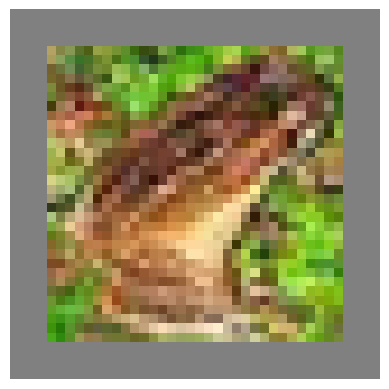

In [32]:
import matplotlib.pyplot as plt
import numpy as np
imgg = Image.open(io.BytesIO(ima[1]))
plt.axis("off")
plt.imshow(np.array(imgg))

In [33]:
print(np.array(imgg).shape)

(40, 40, 3)


Each image is 40x40 pixels with 3 input channels "R","G","B". All the models that are pretrained on the imagenet dataset have input shapes of (224x224x3). Thus, we need to perform standard ImageNet preprocessing on the CIFAR10 dataset

In [13]:
class ImageNetDataset(Dataset):
  """
  Converts image contents into a PyTorch Dataset with standard ImageNet preprocessing.
  """
  def __init__(self, contents):
    self.contents = contents

  def __len__(self):
    
    return len(self.contents)

  def __getitem__(self, index):
    return self._preprocess(self.contents[index])

  def _preprocess(self, content):
    """
    Preprocesses the input image content using standard ImageNet normalization.
    
    See https://pytorch.org/docs/stable/torchvision/models.html.
    """
    image = Image.open(io.BytesIO(content))
    transform = transforms.Compose([
      transforms.Resize(256),                         ### Smaller lenght is convertd to 256 
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image)

In [14]:

def imagenet_model_udf(model_fn):
  """
  Wraps an ImageNet model into a Pandas UDF that makes predictions.
  
  You might consider the following customizations for your own use case:
    - Tune DataLoader's batch_size and num_workers for better performance.
    - Use GPU for acceleration.
    - Change prediction types.
  """

  def predict(content_series_iter : pd.Series) -> pd.DataFrame:
    model = model_fn() # Once per Map
    model.eval()      # Once Per Map ,model file read from memory
    for content_series in content_series_iter:                                                    #Iterates overall all Images 
      dataset = ImageNetDataset(list(content_series))                                           
      loader = DataLoader(dataset, batch_size=64) 
      with torch.no_grad():
        for image_batch in loader:
          predictions = model(image_batch).numpy()                                                # Predictions for all 1000 classes of Mobilenetv2 Training Dataset
          predicted_labels = [x[0] for x in decode_predictions(predictions, top=1)]                       
          yield pd.DataFrame(predicted_labels)
    
        
  return_type = "class: string, desc: string, score:float"
  return pandas_udf(predict,return_type, PandasUDFType.SCALAR_ITER)   
  #Returns a Predict function object as the final user defined function object.
  #Iterates over an Image: A sequence of bytes represented as a 2D array. 
  #Scalar is a series of bytes.    

**Predictions: Mobile net**

In [15]:
# imagenet = imagenet_model_udf(lambda: models.mobilenet_v2(pretrained=True))
mobilenetv2 = imagenet_model_udf(lambda: models.mobilenet_v2(pretrained = True))
mobilenetv2

/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


<function __main__.imagenet_model_udf.<locals>.predict(content_series_iter: pandas.core.series.Series) -> pandas.core.frame.DataFrame>

In [16]:
predictions = df.withColumn("prediction", mobilenetv2(col("content")))
display(predictions.select(col("path"), col("prediction")).limit(5))

DataFrame[path: string, prediction: struct<class:string,desc:string,score:float>]

In [17]:
mobile_net_predictions = predictions.select(col("label"),col("prediction.desc").alias("MobileNet prediction"),col("prediction.score").alias("MobileNet Score") )
mobile_net_predictions.show(20,truncate = False)

+-----+--------------------+---------------+
|label|MobileNet prediction|MobileNet Score|
+-----+--------------------+---------------+
|birds|comic_book          |9.823734       |
|frogs|frilled_lizard      |11.226815      |
|deer |orangutan           |8.612705       |
|frogs|revolver            |9.759069       |
|frogs|waffle_iron         |9.964415       |
|frogs|book_jacket         |10.09747       |
|frogs|muzzle              |11.94763       |
|frogs|three-toed_sloth    |13.096301      |
|birds|patas               |10.979576      |
|frogs|bolo_tie            |10.29219       |
|frogs|cheetah             |9.640568       |
|frogs|muzzle              |10.303909      |
|frogs|fox_squirrel        |8.597261       |
|frogs|leopard             |11.523518      |
|birds|safety_pin          |10.109551      |
|deer |limpkin             |10.380197      |
|frogs|cheetah             |9.61996        |
|deer |fox_squirrel        |12.25812       |
|cats |English_foxhound    |10.38315       |
|frogs|che

**Predictions: Resnet50**

In [18]:
import torch
from torchvision.models import resnet50,ResNet50_Weights, vgg16,VGG16_Weights
Resnet50 = imagenet_model_udf(lambda: resnet50(weights=ResNet50_Weights.DEFAULT))
Resnet50

<function __main__.imagenet_model_udf.<locals>.predict(content_series_iter: pandas.core.series.Series) -> pandas.core.frame.DataFrame>

In [19]:
predictions = df.withColumn("prediction", Resnet50(col("content")))
display(predictions.select(col("path"), col("prediction")).limit(5))

DataFrame[path: string, prediction: struct<class:string,desc:string,score:float>]

In [20]:
resnet50_predictions = predictions.select(col("label"),col("prediction.desc").alias("ResNet50 prediction"),col("prediction.score").alias("ResNet50 Score") )
resnet50_predictions.show(20,truncate = False)

+-----+---------------------------+--------------+
|label|ResNet50 prediction        |ResNet50 Score|
+-----+---------------------------+--------------+
|birds|brambling                  |6.5817957     |
|frogs|tailed_frog                |5.7556643     |
|deer |tusker                     |5.8913913     |
|frogs|muzzle                     |5.5295134     |
|frogs|cheetah                    |7.1604624     |
|frogs|screen                     |5.916838      |
|frogs|shoji                      |4.5856814     |
|frogs|tailed_frog                |6.1878433     |
|birds|patas                      |5.433097      |
|frogs|sidewinder                 |5.265415      |
|frogs|sidewinder                 |5.7072563     |
|frogs|book_jacket                |5.4684696     |
|frogs|tailed_frog                |6.578742      |
|frogs|milk_can                   |5.7039857     |
|birds|howler_monkey              |5.801503      |
|deer |limpkin                    |4.8295956     |
|frogs|limpkin                 

**Predictions: GoogleNet**



In [21]:
GoogleNet = imagenet_model_udf(lambda: torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True))
GoogleNet

<function __main__.imagenet_model_udf.<locals>.predict(content_series_iter: pandas.core.series.Series) -> pandas.core.frame.DataFrame>

In [22]:
predictions = df.withColumn("prediction", GoogleNet(col("content")))
display(predictions.select(col("path"), col("prediction")).limit(5))

DataFrame[path: string, prediction: struct<class:string,desc:string,score:float>]

In [23]:
googlenet_predictions = predictions.select(col("label"),col("prediction.desc").alias("GoogleNet prediction"),col("prediction.score").alias("GoogleNet Score"))
googlenet_predictions.show(20,truncate = False)

+-----+--------------------+---------------+
|label|GoogleNet prediction|GoogleNet Score|
+-----+--------------------+---------------+
|birds|brambling           |8.454064       |
|frogs|book_jacket         |6.4626827      |
|deer |book_jacket         |6.2683506      |
|frogs|book_jacket         |6.6099167      |
|frogs|cheetah             |7.160299       |
|frogs|screen              |7.0333133      |
|frogs|safety_pin          |6.7185173      |
|frogs|screen              |5.701735       |
|birds|patas               |9.558256       |
|frogs|bolo_tie            |6.728154       |
|frogs|book_jacket         |6.834465       |
|frogs|screen              |6.812574       |
|frogs|fox_squirrel        |6.750074       |
|frogs|screen              |6.3442874      |
|birds|screen              |7.789497       |
|deer |book_jacket         |6.203725       |
|frogs|book_jacket         |6.9980235      |
|deer |sorrel              |8.453428       |
|cats |screen              |7.7593718      |
|frogs|boo

In [24]:
VGG16 = imagenet_model_udf(lambda: vgg16(weights=VGG16_Weights.DEFAULT))
VGG16

<function __main__.imagenet_model_udf.<locals>.predict(content_series_iter: pandas.core.series.Series) -> pandas.core.frame.DataFrame>

In [25]:
predictions = df.withColumn("prediction", VGG16(col("content")))
display(predictions.select(col("path"), col("prediction")).limit(5))

DataFrame[path: string, prediction: struct<class:string,desc:string,score:float>]

In [26]:
VGG16_predictions = predictions.select(col("label"),col("prediction.desc").alias("VGG16 prediction"),col("prediction.score").alias("VGG16 Score"))
VGG16_predictions.show(20, truncate = False)

+-----+---------------------------+-----------+
|label|VGG16 prediction           |VGG16 Score|
+-----+---------------------------+-----------+
|birds|screen                     |8.6330185  |
|frogs|frilled_lizard             |11.306978  |
|deer |bulletproof_vest           |7.5320554  |
|frogs|comic_book                 |9.264689   |
|frogs|cheetah                    |10.472668  |
|frogs|book_jacket                |8.955809   |
|frogs|safety_pin                 |8.636215   |
|frogs|three-toed_sloth           |9.986124   |
|birds|fox_squirrel               |11.699705  |
|frogs|rock_python                |8.877836   |
|frogs|hen-of-the-woods           |7.9704266  |
|frogs|book_jacket                |7.852457   |
|frogs|fox_squirrel               |13.552772  |
|frogs|plate_rack                 |10.658487  |
|birds|fox_squirrel               |6.7122188  |
|deer |barn_spider                |9.036906   |
|frogs|cheetah                    |6.843171   |
|deer |fox_squirrel               |8.389

**Conclusion:**



1. From the above predictions reported, ResNet 50 is performing better compared all other models like GoogleNet, MobileNet and VGG16. 

2. The reason being, it has predicted 

 a. brambling(a bird) - for the class "bird"
 
 b. tailed frog       - for the class "frogs"

 c. tusker            - for the class "deer" (may it is drawing correlation between the tusks of the two classes)

3. These predictions are better compared to predictions of other models which are completely different like screen for birds(VGG16), book_jacket for frogs(GoogleNet)....

4. Thus, we can conclude that ResNet50 is working better on CIFAR10 dataset compared to other pretrained models which are trained on ImageNet dataset.  